# Who's the Most Consistent Player in the NBA?

Sports fans and commentators prize "consistency." There's an obvious intuitive appeal to the concept: we want to know that players are not just usually good but can be relied upon to be good every night. That said, "consistency" is usually defined in a vague or subjective manner within a sports context. For example, one of the recurring themes of the famously snarky 2000s sports blog "Fire Joe Morgan" was the (ironically) inconsistent way that sports commentators tended to use the term. 

So how can we define "consistency" in a consistent, robust way? Several popular pieces have tried to formalize this concept (e.g., https://www.theringer.com/nba/2020/1/6/21050900/most-least-consistent-nba-player), but I have found these efforts unsatisfactory. In this notebook, I'll try to do build a better consistency metric via the statistical concepts of <i>standard deviation</i> and <i>entropy</i>.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy

import calculate
import scrape

In [ ]:
import importlib
importlib.reload(scrape)

## Gathering the Data

For the purpose of this analysis, we're going to acquire all player-level game logs from basketball-reference.com. This is a comprehensive website that is relatively easy to scrape. The site keeps an index of all player pages, organized alphabetically, on URLs that are formatted 'https://www.basketball-reference.com/players/{letter}/'. We can acquire all player homepage URLs from those pages, as well as the years in which the players were active. Once we have that information, we can rely on the fact that all player game-logs URLs are formatted 'https://www.basketball-reference.com/players/{letter}/{player}/gamelog/{year}' to systematically query every year's games for every player in the league's history. Once we've done that, it is relatively simple to use the BeautifulSoup library to locate the table of statistics, find all column names, and store each game's values in a dictionary.

The basketball-reference.com website is, fortunately, friendly to these kinds of exercises and does not work very hard to rate-limit requests. So long as we include a small amount of error-handling logic in our scraping script to handle occasional timeouts and a simple retry step, we can be confident that we are getting a comprehsive account of all player gamelogs. To accelerate the process, I have multi-threaded the requests, which reduces the time to scrape the player pages from around a fully day down to a few hours.

In [ ]:
all_players = scrape.get_all_player_records()

Since the result is a deeply nested dictionary, we will now convert this to a multi-indexed dataframe. We will also perform a few other miscellaneous cleaning functions, like casting all of the string-format numerical entries to floats.

In [ ]:
player_df = scrape.convert_dict_to_df(all_players)

## Defining "Consistency" in a Statistical Context

What does "consistency" mean for a basketball player? We might say that a perfectly consistent player a) plays every game, and b) performs just about the same way every game. We can measure this in several ways:

1. Standard Deviation: Essentially, the standard deviation of the statistic across all games. We can normalize this value to a 0-1 scale by dividing by half the maximum value of the distribution (i.e., the maximum value for the standard deviation).

2. Shannon Entropy: Essentially, a measure of how evenly the probability of a given event is distributed across possible outcomes, as given by the formula:

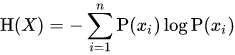

We can extend this idea to a basketball season by dividing the total of the statistic for a given game by the total for the whole season, and then taking the log in the base of the number of games that season.

3. Unique Values: We can divide the number of unique values for a statistic, then divide by the number of games.


These methods have relative advantages and disadvantages. While all will rate a player who performs exactly the same way in every game as the most consistent, they will have different views of who is the most inconsistent player. Entropy will maximize inconsistency for a player who concentrates all performance into a single game. Standard deviation will maximize inconsistency for a player who vacillates between his best and worst performances equally. Uniqueness will maximize inconsistency for a player who never has the same performance twice.

Let's take the following players as examples, looking solely at points:

1. Player A: 82 games, 10 pts every game
2. Player B: 82 games, 30 pts in 1 game and 0 in the other 81
3. Player C: 82 games, with random point totals between 0 and 30
4. Player D: 30 DNPs, 25 games with 0 pts, and 27 games with random point totals between 0 and 30
5. Player E: 82 games, 41 games with 30 pts, 41 games with 0 pts

In [ ]:
sample_dict = {
    'Player A': np.repeat(10, 82),
    'Player B': np.append(np.zeros(82), [30]),
    'Player C': np.array(random.choices(range(30), k=82)),
    'Player D': np.append(np.append(np.empty(30), np.zeros(25)), np.array(random.choices(range(30), k=27))),
    'Player E': np.append(np.repeat(30, 41), np.zeros(41))
}
score_dict = {key: {'entropy_score': calculate.measure_vector_entropy(value, base=82),
                    'deviation_score': calculate.measure_vector_deviation(value),
                    'unique_score': calculate.measure_vector_uniqueness(value)
                   } for key, value in list(sample_dict.items())}
score_df = pd.DataFrame(score_dict).transpose()

In [ ]:
fig, ax = plt.subplots()
width = 0.25
x = np.arange(len(score_df))
p1 = ax.bar(x - width, score_df['entropy_score'], width, label='Entropy_Score')
p2 = ax.bar(x, score_df['deviation_score'], width, label='Deviation_Score')
p3 = ax.bar(x + width, score_df['unique_score'], width, label='Uniqueness_Score')
ax.set_ylabel('Scores')
ax.set_title('Consistency Scores for Sample Players')
ax.set_xticklabels([''] + score_df.index.tolist())
ax.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

The absolute values here matter less than the relative ones. As we can see, ranking from most to least consistent, Deviation ranks A, B, C, D, E; Entropy ranks A, C, E, D, B; and Uniqueness ranks A, B, E, D, C. Which of these feels like the "best" ranking? It's hard to say. The nebulousness of the concept of "consistency" may be one reason why fans and analysts use the term so haphazardly.

For the purpose of this exercise, I will use a combination of variance and entropy to define consistency. I will not use uniqueness, simply because for lower-total statistics where the vast majority of totals will be concentrated in single-digit values (e.g., assists), this statistic will lose a great deal of its descriptive power. Entropy and standard deviation have enough drawbacks used on their own that it might not be wise to use either without the other. Perhaps the most obvious case is for a player who only plays 1 game. Entropy has no choice but to declare this player to have a low-consistency score (all data concentrated in one spot), while standard deviation will give it a high-consistency score whether we count all missed games as 0 (in which case most games are close to the near-0 average) or ignore them (in which case the single game is consistent with itself).

## Selecting and Normalizing Features

basketball-reference.com gives us just about every officially-recorded statistic at the gamelog level. However, we won't necessary want to use all of these statistics in our analysis (or at least not in their rawest forms), for the following reasons:

1. Leakage: Some statistics are directly correlated, like field-goals made and total points. Others are more indirectly related but still obviously correlated, like minutes played with every other statistic.

2. Clarity: We want to emphasize the major counting statistics rather than incidental counting statistics (e.g., personal fouls) or non-counting statistics (e.g., plus/minus)

3. Robustness: Not all statistics have been kept consistently over time. For example, the recording of turnovers, blocks, and steals, as well as the distinction between offensive and defensive rebounds, didn't occur until the mid-1970s. This will make it difficult to use any of them in our analysis. In particular, versions of this model that attempted to incorporate steals and blocks always ended up privileging either the pre-70s or post-70s players, because steals and blocks (likely due to their relatively low raw totals in a given game) are distributed so differently from other statistics that they could not help but bias the results.

4. Spread: We will also need to make sure that the scores are sensibly and comparably distributed. For example, in practice, the absolute entropy score for any player who plays regularly will likely tend to be high, because it is simply not plausible for such a player to score all of their points in a small number of games. Similarly, entropy might not be distributed the same way for, say, points as for assists. If we want scores to have similar weight in differentiating players, we will need them all to have a substantial (and preferably similar) distribution of values. This means we may have to transform the raw values.

5. Historical Accidents: Entropy requires a base, and to normalize scores to a 0-1 range we should use the number of possible games as the base. However, not every season has the same number of games. So we will have to dynamically change the base to align with the total number of games played by each team each season.

For the sake of the exercise, we will analyze only the Big Three statistics of total points, rebounds, and assists.

Let's see how deviation and entropy scores are distributed on a player-season level for those three statistics.

In [ ]:
player_df['total_games'] = player_df['year'].apply(lambda x: calculate.get_games_from_year(x))
test_set = player_df.loc[player_df.total_games == 82,:]
ent_distribution = test_set.groupby(['name', 'player_key', 'year'])[[*calculate.norm_factor]] \
    .agg(lambda vec: calculate.measure_vector_entropy(vec, base=82))
std_distribution = test_set.groupby(['name', 'player_key', 'year'])[[*calculate.norm_factor]] \
    .agg(lambda vec: calculate.measure_vector_deviation(vec))

In [ ]:
for col in std_distribution.columns:
    plt.hist(std_distribution[col], bins=20)
    plt.title('{feat} Deviation Distribution'.format(feat=col))
    plt.xlabel('Deviation Score')
    plt.ylabel('Number of Player-Seasons')
    plt.show()

It looks like the deviation scores are, by eye, close enough to normal that we can be content with them as is. We needn't worry too much about transforming the data. Now let's look at entropy.

In [ ]:
for col in ent_distribution.columns:
    plt.hist(ent_distribution[col], bins=20)
    plt.title('{feat} Entropy Distribution'.format(feat=col))
    plt.xlabel('Entropy Score')
    plt.ylabel('Number of Player-Seasons')
    plt.tight_layout()
    plt.show()

The same is not true of the entropy scores, which is likely due (as mentioned above) to the inherent bias toward high scores. These distributions will not easily normalize. Box-Cox, for example, tends not to improve the situation. As a kind of fudge-factor compromise, the best we can do here is to apply an exponent onto the raw total to force the scores toward essentially the same (non-normal) distribution, where the highest density in the distribution is around 0.8 and the median is around 0.67. This occurs if we apply a power transformation of 3.5 to points, 3 to rebounds, and 2 to assists.

In [ ]:
for col in ent_distribution.columns:
    print("Mod median of {col} is {med}".format(col=col, med=np.nanmedian([ent_distribution[col] ** calculate.norm_factor[col]])))
    plt.hist(ent_distribution[col] ** calculate.norm_factor[col], bins=20)
    plt.title('Modified {feat} Entropy Distribution'.format(feat=col))
    plt.xlabel('Entropy Score')
    plt.ylabel('Number of Player-Seasons')
    plt.tight_layout()
    plt.show()

Because entropy scores will still end up higher and more clustered, still, than deviation scores, we will square the final entropy score. This will make the median score somewhat lower than the deviation score, but although the most common scores will cluster a bit higher. This will have the effect of roughly equalizing the impact on the final scores.

## Running the Model

Now, let's run the model and start asking it questions. For example, who had the most consistent season in NBA history?

In [ ]:
season_consistency = player_df.groupby(['name', 'player_key', 'year']).agg(calculate.measure_group_consistency, group='player_season').reset_index()
season_consistency['player_year'] = season_consistency['name'] + '_' + season_consistency['year'].astype(str)

In [ ]:
top_15 = season_consistency.sort_values('consistency_score', ascending=False).iloc[:15,:] \
    .sort_values('consistency_score')

plt.barh(top_15['player_year'], top_15['consistency_score'], color='orange')
plt.title('Most Consistent Player-Seasons')
plt.ylabel('Player/Year')
plt.xlabel('Consistency Score')
plt.xlim(0.75, 0.85)
plt.show()

These results make intuitive sense, and the fact that they span the game's history indicates that there doesn't seem to be too much era-based bias in the method. All of the players have reputations as reliable, star-level performers, and the fact that several appear multiple times (Malone, Robertson, and Abdul-Jabbar) shows a degree of meta-consistency. But there are some surprises here. 2002, for example, was a middling year for Gary Payton's Seattle Supersonics, bringing the point guard his usual individual accolades but little attention beyond that. However, he was remarkably reliable that year. He played and started all 82 games; he averaged 22 ppg, never scoring fewer than 11 and only scoring more than 30 5 times; he averaged 9 assists, with only two games below 5 and two above 13; and he averaged just under 5 rebounds, with only 5 games above 7. Who at the time registered that he was having perhaps the most consistent year in NBA history?

Now let's ask another question: who has had the most consistency on a season-to-season basis? In other words, whether or not they were consistent in the individual games of a season, who maintained consistent final season totals over the course of their career? Because we will want to insist that players had lengthy careers as a criterion for consistency, we will use 10 as the entropy base for players who played ten or fewer seasons, or use the player's total number of seasons as the base for those with longer careers.

In [ ]:
full_season_consistency = player_df.groupby(['name', 'player_key']).apply(calculate.measure_group_consistency, group='sum_season').reset_index()


In [ ]:
top_15 = full_season_consistency.sort_values('consistency_score', ascending=False).iloc[:15,:] \
    .sort_values('consistency_score')

plt.barh(top_15['name'], top_15['consistency_score'], color='orange')
plt.title('Most Consistent Player Season-Totals')
plt.ylabel('Player/Year')
plt.xlabel('Consistency Score')
plt.xlim(0.75, 0.87)
plt.show()

That Lebron James is the most consistent player in history by this metric is unsurprising, as he has played consistently at a star level for 18 years, but many other players on this list were role players, and in some cases were even considered as disappointments. Take Marvin Williams, famously taken second in the 2005 draft (ahead of Chris Paul) and widely regarded as a bust. Yet he played for 15 years in the league, always recording at least 50 games per year and consistently notching about 800 points, 375 rebounds, and 90 assists.

Last, let's look at game-level consistency across an entire career. Who reliably put up their numbers, game-in and game-out, over the course of a decade or more? For this exercise, we will use as our entropy base the total number of games possible in each season the player was active, with a minimum of 820 (ten normal 82-game seasons).

In [ ]:
career_consistency = player_df.groupby(['name', 'player_key']).agg(calculate.measure_group_consistency, group='career').reset_index()

In [ ]:
top_15 = career_consistency.sort_values('consistency_score', ascending=False).iloc[:15,:] \
    .sort_values('consistency_score')

plt.barh(top_15['name'], top_15['consistency_score'], color='orange')
plt.title('Most Consistent Careers')
plt.ylabel('Player/Year')
plt.xlabel('Consistency Score')
plt.xlim(0.72, 0.81)
plt.show()

This list also has a few surprising results. The presence of James, Malone, Duncan, and Abdul-Jabbar in the Top 5 is as expected, as these have been the NBA's gold-standard iron men superstars. But Wilt Chamberlain is a surprise at #3, given the three very different phases of his career (the Warriors' record-breaking scorer, the 76ers' triple-double machine, and the Lakers' defensive anchor). His remarkably consistent rebounding score helps him stay high on the leaderboard. Furthermore, 1980s journeyman guard Reggie Theus stands out as an unexpected entry at #6. Though he labored largely unwatched for the pre-Jordan Bulls and in-transition Sacremento Kings, he maintained remarkably consistent averages of around 18 ppg, 6 apg, and 3 rpg for over a decade.

## Conclusion

What does this exercise tell us? Perhaps not much in the way of new insights about the game. But I prefer quantitative precision in language and always want to test vague impressions against data. In many cases this metric confirms what we already thought. But in others, it brings to light unexpected or forgotten achievements. (Alvan Adams, your work has been remembered!) And at the least it can settle bar bets: Hakeem Olajuwon may have been a better player than Patrick Ewing, but at least Ewing was very slightly more consistent!

In [ ]:
career_consistency.loc[career_consistency.player_key == 'ewingpa01',:]

In [ ]:
career_consistency.loc[career_consistency.name == 'Hakeem Olajuwon',:]